In [1]:
import numpy as np
import os
from numpy import genfromtxt
from pathlib import Path
import math
from scipy.signal import savgol_filter

In [2]:
#  Functions

def eulers_2_rot_matrix(x):
    """
    EULER_2_ROT_MATRIX transforms a set of euler angles into a rotation  matrix 
    input vector of euler angles 
    [gamma_x, beta_y, alpha_z]  are ZYX Eulers angles in radians
    """
    gamma_x=x[0];beta_y=x[1];alpha_z=x[2];
    rot_z = rotz(alpha_z)
    rot_y = roty(beta_y)
    rot_x = rotx(gamma_x)
    
    R = rot_z * rot_y * rot_x
    return R

def rotx(t):
    # ROTX Rotation about X axis
    ct = math.cos(t);
    st = math.sin(t);
    r =  np.matrix([[1,	0,	0],
                    [0,	ct,	-st],
                    [0,	st,	ct]]);
    return r

def roty(t):
    # ROTY Rotation about Y axis
    ct = math.cos(t);
    st = math.sin(t);
    r =  np.matrix([[ct,	0,	st],
                    [0,	1,	0],
                    [-st	,0,	ct]]);
    return r

def rotz(t):
    # ROTZ Rotation about Z axis
    ct = math.cos(t);
    st = math.sin(t);
    r = np.matrix([[ct, -st, 0],
                   [st, ct, 0],
                   [0, 0, 1]]);
    return r
    

# Kinect data only has only one absolute position so we need to calculate absolute positions for remaining
def rel2abs_kinect(pos, ang, skel):
    num_joints, dimensions, num_frames = skel.shape
    for i in range(num_frames):
        """
        1 Waist (absolute)
        2 Spine
        3 Chest
        4 Neck
        5 Head
        6 Head tip
        7 Left collar
        8 Left upper arm 
        9 Left forearm
        10 Left hand
        11 Right collar
        12 Right upper arm 
        13 Right forearm
        14 Right hand
        15 Left upper leg 
        16 Left lower leg 
        17 Left foot 
        18 Left leg toes
        19 Right upper leg 
        20 Right lower leg 
        21 Right foot
        22 Right leg toes
        """
        joint = pos[:,:,i]
        joint_ang = ang[:,:,i]
        
        # chest, neck, head
        rot_1 = eulers_2_rot_matrix(joint_ang[0,:]*np.pi/180)
        joint[1,:] =  rot_1@joint[1,:] + joint[0,:]
        rot_2 = rot_1*eulers_2_rot_matrix(joint_ang[1,:]*np.pi/180)
        joint[2,:] =  rot_2@joint[2,:] +  joint[1,:]
        rot_3 = rot_2*eulers_2_rot_matrix(joint_ang[2,:]*np.pi/180)
        joint[3,:] =  rot_3@joint[3,:] +  joint[2,:]
        rot_4 = rot_3*eulers_2_rot_matrix(joint_ang[3,:]*np.pi/180)
        joint[4,:] =  rot_4@joint[4,:] +  joint[3,:]
        rot_5 = rot_4*eulers_2_rot_matrix(joint_ang[4,:]*np.pi/180)
        joint[5,:] =  rot_5@joint[5,:] +  joint[4,:]
        
        # left-arm
        rot_6 = eulers_2_rot_matrix(joint_ang[2,:]*np.pi/180)
        joint[6,:] =  rot_6@joint[6,:] +  joint[2,:]
        rot_7 = rot_6*eulers_2_rot_matrix(joint_ang[6,:]*np.pi/180)
        joint[7,:] =  rot_7@joint[7,:] +  joint[6,:]
        rot_8 = rot_7*eulers_2_rot_matrix(joint_ang[7,:]*np.pi/180)
        joint[8,:] = rot_8@joint[8,:] +  joint[7,:]
        rot_9 = rot_8*eulers_2_rot_matrix(joint_ang[8,:]*np.pi/180)
        joint[9,:] = rot_9@joint[9,:] +  joint[8,:]
        
        # right-arm
        rot_10 = eulers_2_rot_matrix(joint_ang[2,:]*np.pi/180)
        joint[10,:] =  rot_10@joint[10,:] +  joint[2,:]
        rot_11 = rot_10*eulers_2_rot_matrix(joint_ang[10,:]*np.pi/180)
        joint[11,:] =  rot_11@joint[11,:] +  joint[10,:]
        rot_12 = rot_11*eulers_2_rot_matrix(joint_ang[11,:]*np.pi/180)
        joint[12,:] = rot_12@joint[12,:] +  joint[11,:]
        rot_13 = rot_12*eulers_2_rot_matrix(joint_ang[12,:]*np.pi/180)
        joint[13,:] = rot_13@joint[13,:] +  joint[12,:]
        
        # left-leg
        rot_14 = eulers_2_rot_matrix(joint_ang[0,:]*np.pi/180)
        joint[14,:] =  rot_14@joint[14,:] +  joint[0,:]
        rot_15 = rot_14*eulers_2_rot_matrix(joint_ang[14,:]*np.pi/180)
        joint[15,:] =  rot_15@joint[15,:] +  joint[14,:]
        rot_16 = rot_15*eulers_2_rot_matrix(joint_ang[15,:]*np.pi/180)
        joint[16,:] = rot_16@joint[16,:] +  joint[15,:]
        rot_17 = rot_16*eulers_2_rot_matrix(joint_ang[16,:]*np.pi/180)
        joint[17,:] = rot_17@joint[17,:] +  joint[16,:]
        
        # right-leg
        rot_18 = eulers_2_rot_matrix(joint_ang[0,:]*np.pi/180)
        joint[18,:] =  rot_18@joint[18,:] +  joint[0,:]
        rot_19 = rot_18*eulers_2_rot_matrix(joint_ang[18,:]*np.pi/180)
        joint[19,:] =  rot_19@joint[19,:] +  joint[18,:]
        rot_20 = rot_19*eulers_2_rot_matrix(joint_ang[19,:]*np.pi/180)
        joint[20,:] = rot_20@joint[20,:] +  joint[19,:]
        rot_21 = rot_20*eulers_2_rot_matrix(joint_ang[20,:]*np.pi/180)
        joint[21,:] = rot_21@joint[21,:] +  joint[20,:]
        skel[:,:,i] = joint
    
    return skel

def getCommonFilenamePart(fileA, fileB, separator):
    partA = fileA.split(separator)
    partB = fileB.split(separator)
    
    common_components = []
    
    for (a, b) in zip(partA, partB):
        if (a == b):
            common_components.append(b) # keep adding while string match
        else:
            break;
    return separator.join(common_components)

In [3]:
# KINECT - Filtering the raw data

# Position directory setup
correct_dir_pos_orig_kinect = "Segmented Movements/Kinect/Positions"
incorrect_dir_pos_orig_kinect = "Incorrect Segmented Movements/Kinect/Positions"
correct_dir_ang_orig_kinect = "Segmented Movements/Kinect/Angles"
incorrect_dir_ang_orig_kinect = "Incorrect Segmented Movements/Kinect/Angles"

path_to_correct_pos_kinect = Path(correct_dir_pos_orig_kinect)
path_to_incorrect_pos_kinect = Path(incorrect_dir_pos_orig_kinect)
path_to_correct_ang_kinect = Path(correct_dir_ang_orig_kinect)
path_to_incorrect_ang_kinect = Path(incorrect_dir_ang_orig_kinect)
paths_original_kinect = [path_to_correct_pos_kinect, path_to_incorrect_pos_kinect, path_to_correct_ang_kinect, path_to_incorrect_ang_kinect]

# Angles directory setup
correct_dir_pos_filt_kinect = "Filtered Segmented Movements/Kinect/Positions"
incorrect_dir_pos_filt_kinect = "Filtered Incorrect Segmented Movements/Kinect/Positions"
correct_dir_ang_filt_kinect = "Filtered Segmented Movements/Kinect/Angles"
incorrect_dir_ang_filt_kinect = "Filtered Incorrect Segmented Movements/Kinect/Angles"

# Create Path objects
path_to_correct_filtered_pos_kinect = Path(correct_dir_pos_filt_kinect)
path_to_incorrect_filtered_pos_kinect = Path(incorrect_dir_pos_filt_kinect)
path_to_correct_filtered_ang_kinect = Path(correct_dir_ang_filt_kinect)
path_to_incorrect_filtered_ang_kinect = Path(incorrect_dir_ang_filt_kinect)

# Create directories
path_to_correct_filtered_pos_kinect.mkdir(parents=True, exist_ok=True)
path_to_incorrect_filtered_pos_kinect.mkdir(parents=True, exist_ok=True)
path_to_correct_filtered_ang_kinect.mkdir(parents=True, exist_ok=True)
path_to_incorrect_filtered_ang_kinect.mkdir(parents=True, exist_ok=True)

# for directory in paths_original_kinect:
#     for file_path in directory.iterdir():
#         if file_path.is_file():
#             read_data = genfromtxt(file_path, delimiter=',')        
#             # Work through 3 columns at a time (one joint)
#             for i in range(0, read_data.shape[1], 3):
#                 joint_coordinate_slice = read_data[:, i:i+3]
#                 filtered_joint = joint_coordinate_slice.copy()

#                 # Use Savitzky-Golay Smoothing filter on each dimension separately
#                 # Window length = 5
#                 # Polynomial order = 2
#                 for j in range(0, 3):
#                     dimension_slice = filtered_joint[:, j]
#                     # apply filter Savitzky-Golay filter to the dimension of joint across all time points
#                     filtered_data = savgol_filter(dimension_slice, window_length=5, polyorder=2)
#                     read_data[:, i+j] = filtered_data # Save new positional data

#             smooth_file = "smooth_" + file_path.name
#             # Save the filtered data as correct or incorrect in new directories
#             if "angle" in file_path.name:
#                 if "Incorrect" in str(directory.parent):
#                     np.savetxt(f'{incorrect_dir_ang_filt_kinect}/{smooth_file}', read_data, delimiter=',', fmt='%f')
#                 else:
#                     np.savetxt(f'{correct_dir_ang_filt_kinect}/{smooth_file}', read_data, delimiter=',', fmt='%f')
#             else:
#                 if "Incorrect" in str(directory.parent):
#                     np.savetxt(f'{incorrect_dir_pos_filt_kinect}/{smooth_file}', read_data, delimiter=',', fmt='%f')
#                 else:
#                     np.savetxt(f'{correct_dir_pos_filt_kinect}/{smooth_file}', read_data, delimiter=',', fmt='%f')

In [4]:
# VICON - Filtering the raw data

# Position directory setup
correct_dir_pos_orig_vicon = "Segmented Movements/Vicon/Positions"
incorrect_dir_pos_orig_vicon = "Incorrect Segmented Movements/Vicon/Positions"
correct_dir_ang_orig_vicon = "Segmented Movements/Vicon/Angles"
incorrect_dir_ang_orig_vicon = "Incorrect Segmented Movements/Vicon/Angles"

path_to_correct_pos_vicon = Path(correct_dir_pos_orig_vicon)
path_to_incorrect_pos_vicon = Path(incorrect_dir_pos_orig_vicon)
path_to_correct_ang_vicon = Path(correct_dir_ang_orig_vicon)
path_to_incorrect_ang_vicon = Path(incorrect_dir_ang_orig_vicon)
paths_original_vicon = [path_to_correct_pos_vicon, path_to_incorrect_pos_vicon, path_to_correct_ang_vicon, path_to_incorrect_ang_vicon]

# Angles directory setup
correct_dir_pos_filt_vicon = "Filtered Segmented Movements/Vicon/Positions"
incorrect_dir_pos_filt_vicon = "Filtered Incorrect Segmented Movements/Vicon/Positions"
correct_dir_ang_filt_vicon = "Filtered Segmented Movements/Vicon/Angles"
incorrect_dir_ang_filt_vicon = "Filtered Incorrect Segmented Movements/Vicon/Angles"

# Create Path objects
path_to_correct_filtered_pos_vicon = Path(correct_dir_pos_filt_vicon)
path_to_incorrect_filtered_pos_vicon = Path(incorrect_dir_pos_filt_vicon)
path_to_correct_filtered_ang_vicon = Path(correct_dir_ang_filt_vicon)
path_to_incorrect_filtered_ang_vicon = Path(incorrect_dir_ang_filt_vicon)

# Create directories
path_to_correct_filtered_pos_vicon.mkdir(parents=True, exist_ok=True)
path_to_incorrect_filtered_pos_vicon.mkdir(parents=True, exist_ok=True)
path_to_correct_filtered_ang_vicon.mkdir(parents=True, exist_ok=True)
path_to_incorrect_filtered_ang_vicon.mkdir(parents=True, exist_ok=True)

# for directory in paths_original_vicon:
#     for file_path in directory.iterdir():
#         if file_path.is_file():
#             read_data = genfromtxt(file_path, delimiter=',')        
#             # Work through 3 columns at a time (one joint)
#             # Avoids case like m10_s05_e09_positions_inc.txt, (117,) in Vicon dataset
#             if (len(read_data.shape) != 2):
#                 print('read_data.shape for file: ', f'{file_path.name}, {read_data.shape}');
#                 continue;
#             for i in range(0, read_data.shape[1], 3):
#                 joint_coordinate_slice = read_data[:, i:i+3]
#                 filtered_joint = joint_coordinate_slice.copy()

#                 # Use Savitzky-Golay Smoothing filter on each dimension separately
#                 # Window length = 5
#                 # Polynomial order = 2
#                 for j in range(0, 3):
#                     dimension_slice = filtered_joint[:, j]
#                     # apply filter Savitzky-Golay filter to the dimension of joint across all time points
#                     filtered_data = savgol_filter(dimension_slice, window_length=5, polyorder=2)
#                     read_data[:, i+j] = filtered_data # Save new positional data

#             smooth_file = "smooth_" + file_path.name
#             # Save the filtered data as correct or incorrect in new directories
#             if "angle" in file_path.name:
#                 if "Incorrect" in str(directory.parent):
#                     np.savetxt(f'{incorrect_dir_ang_filt}/{smooth_file}', read_data, delimiter=',', fmt='%f')
#                 else:
#                     np.savetxt(f'{correct_dir_ang_filt}/{smooth_file}', read_data, delimiter=',', fmt='%f')
#             else:
#                 if "Incorrect" in str(directory.parent):
#                     np.savetxt(f'{incorrect_dir_pos_filt}/{smooth_file}', read_data, delimiter=',', fmt='%f')
#                 else:
#                     np.savetxt(f'{correct_dir_pos_filt}/{smooth_file}', read_data, delimiter=',', fmt='%f')

In [5]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

# Visualization 3D 
def visualize_skeleton(skel, gif_name):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection="3d")
    # order of joint connections
    J = np.array([[3, 5, 4, 2, 1, 2, 6, 7, 8, 2, 10, 11, 12, 0, 14, 15, 16, 0, 18, 19, 20],
                  [2, 4, 2, 1, 0, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]])

    def get_plot(i):
        ax.cla()

        ax.set_title('3D plot using transformed data')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')

        ax.set_box_aspect([1, 1, 1])

        ax.set_xlim([-250, -140])
        ax.set_ylim([-100, 100])
        ax.set_zlim([0, 200])

        joint = skel[:, :, i]

        for j in range(J.shape[1]):
            p1 = joint[J[0, j], :]
            p2 = joint[J[1, j], :]
            ax.plot([p1[2],p2[2]],[p1[0], p2[0]], [p1[1], p2[1]], 'bo-')

    anim = animation.FuncAnimation(fig, get_plot, blit=False, frames=skel.shape[2])
    anim.save(gif_name, writer='Pillow', fps=30)

In [8]:
# Create skeletal data from each files filtered position + angular data
paths_filtered = [(path_to_correct_filtered_pos_kinect, path_to_correct_filtered_ang_kinect),
                  (path_to_incorrect_filtered_pos_kinect, path_to_incorrect_filtered_ang_kinect)]
#                   (path_to_correct_filtered_pos_vicon, path_to_correct_filtered_ang_vicon),
#                   (path_to_incorrect_filtered_pos_vicon, path_to_incorrect_filtered_ang_vicon)]

paths_normal = [(path_to_correct_pos_kinect, path_to_correct_ang_kinect),
                  (path_to_incorrect_pos_kinect, path_to_incorrect_ang_kinect),
                  (path_to_correct_filtered_pos_vicon, path_to_correct_ang_vicon),
                  (path_to_incorrect_pos_vicon, path_to_incorrect_ang_vicon)]

# Initialize Skeletal data directory if doesn't already exist
skel_kinect = "Skeletal Data Filtered/Kinect"
skel_vicon = "Skeletal Data Filtered/Vicon"
path_skel_kinect = Path(skel_kinect)
path_skel_vicon = Path(skel_vicon)
path_skel_kinect.mkdir(parents=True, exist_ok=True)
path_skel_vicon.mkdir(parents=True, exist_ok=True)

for pos_dir, ang_dir in paths_filtered:
    # Make sure files are sorted the same way
    pos_sorted = sorted(os.listdir(pos_dir))
    ang_sorted = sorted(os.listdir(ang_dir))
    
    inc_dir = "Incorrect" in str(pos_dir)
    
    # Zip the lists together to iterate at the same time
    for (pos_file, ang_file) in zip(pos_sorted, ang_sorted):
        pos_file_path = f'{pos_dir}/{pos_file}'
        ang_file_path = f'{ang_dir}/{ang_file}'
        
        pos_data = genfromtxt(pos_file_path, delimiter=',')
        ang_data = genfromtxt(ang_file_path, delimiter=',')
        
        assert (pos_data.shape == ang_data.shape) # Make sure data size matches
        
        # Skeletal data has shape [Joints x XYZ x Frames]
        frames, xyz_joints = pos_data.shape
        dimensions = 3
        joint_count = xyz_joints // dimensions
        
        # Reshape into [Joints x XYZ x Frames] for position and angular data
        pos_data = pos_data.T.reshape(joint_count, 3, frames)
        ang_data = ang_data.T.reshape(joint_count, 3, frames )
        
        # Initialize empty matrix for skeleton
        skeleton = np.zeros((joint_count, dimensions, frames))
        
        # Kinect data relative to absolute coordinates
        if "Kinect" in str(pos_dir):
            skeleton = rel2abs_kinect(pos_data, ang_data, skeleton)
            file_name = ""
            if (inc_dir == True):
                file_name = getCommonFilenamePart(pos_file, ang_file, '_') + "_inc" +"_skeleton" 
            else :
                file_name = getCommonFilenamePart(pos_file, ang_file, '_') + "_skeleton"
            
            print("Saving file: ", file_name)
            np.save(f'{skel_kinect}/{file_name}', skeleton)


Saving file:  smooth_m01_s01_e01_skeleton
Saving file:  smooth_m01_s01_e02_skeleton
Saving file:  smooth_m01_s01_e03_skeleton
Saving file:  smooth_m01_s01_e04_skeleton
Saving file:  smooth_m01_s01_e05_skeleton
Saving file:  smooth_m01_s01_e06_skeleton
Saving file:  smooth_m01_s01_e07_skeleton
Saving file:  smooth_m01_s01_e08_skeleton
Saving file:  smooth_m01_s01_e09_skeleton
Saving file:  smooth_m01_s01_e10_skeleton
Saving file:  smooth_m01_s02_e01_skeleton
Saving file:  smooth_m01_s02_e02_skeleton
Saving file:  smooth_m01_s02_e03_skeleton
Saving file:  smooth_m01_s02_e04_skeleton
Saving file:  smooth_m01_s02_e05_skeleton
Saving file:  smooth_m01_s02_e06_skeleton
Saving file:  smooth_m01_s02_e07_skeleton
Saving file:  smooth_m01_s02_e08_skeleton
Saving file:  smooth_m01_s02_e09_skeleton
Saving file:  smooth_m01_s02_e10_skeleton
Saving file:  smooth_m01_s03_e01_skeleton
Saving file:  smooth_m01_s03_e02_skeleton
Saving file:  smooth_m01_s03_e03_skeleton
Saving file:  smooth_m01_s03_e04_s

Saving file:  smooth_m02_s10_e07_skeleton
Saving file:  smooth_m02_s10_e08_skeleton
Saving file:  smooth_m02_s10_e09_skeleton
Saving file:  smooth_m02_s10_e10_skeleton
Saving file:  smooth_m03_s01_e01_skeleton
Saving file:  smooth_m03_s01_e02_skeleton
Saving file:  smooth_m03_s01_e03_skeleton
Saving file:  smooth_m03_s01_e04_skeleton
Saving file:  smooth_m03_s01_e05_skeleton
Saving file:  smooth_m03_s01_e06_skeleton
Saving file:  smooth_m03_s01_e07_skeleton
Saving file:  smooth_m03_s01_e08_skeleton
Saving file:  smooth_m03_s01_e09_skeleton
Saving file:  smooth_m03_s01_e10_skeleton
Saving file:  smooth_m03_s02_e01_skeleton
Saving file:  smooth_m03_s02_e02_skeleton
Saving file:  smooth_m03_s02_e03_skeleton
Saving file:  smooth_m03_s02_e04_skeleton
Saving file:  smooth_m03_s02_e05_skeleton
Saving file:  smooth_m03_s02_e06_skeleton
Saving file:  smooth_m03_s02_e07_skeleton
Saving file:  smooth_m03_s02_e08_skeleton
Saving file:  smooth_m03_s02_e09_skeleton
Saving file:  smooth_m03_s02_e10_s

Saving file:  smooth_m04_s10_e03_skeleton
Saving file:  smooth_m04_s10_e04_skeleton
Saving file:  smooth_m04_s10_e05_skeleton
Saving file:  smooth_m04_s10_e06_skeleton
Saving file:  smooth_m04_s10_e07_skeleton
Saving file:  smooth_m04_s10_e08_skeleton
Saving file:  smooth_m04_s10_e09_skeleton
Saving file:  smooth_m04_s10_e10_skeleton
Saving file:  smooth_m05_s01_e01_skeleton
Saving file:  smooth_m05_s01_e02_skeleton
Saving file:  smooth_m05_s01_e03_skeleton
Saving file:  smooth_m05_s01_e04_skeleton
Saving file:  smooth_m05_s01_e05_skeleton
Saving file:  smooth_m05_s01_e06_skeleton
Saving file:  smooth_m05_s01_e07_skeleton
Saving file:  smooth_m05_s01_e08_skeleton
Saving file:  smooth_m05_s01_e09_skeleton
Saving file:  smooth_m05_s01_e10_skeleton
Saving file:  smooth_m05_s02_e01_skeleton
Saving file:  smooth_m05_s02_e02_skeleton
Saving file:  smooth_m05_s02_e03_skeleton
Saving file:  smooth_m05_s02_e04_skeleton
Saving file:  smooth_m05_s02_e05_skeleton
Saving file:  smooth_m05_s02_e06_s

Saving file:  smooth_m06_s09_e09_skeleton
Saving file:  smooth_m06_s09_e10_skeleton
Saving file:  smooth_m06_s10_e01_skeleton
Saving file:  smooth_m06_s10_e02_skeleton
Saving file:  smooth_m06_s10_e03_skeleton
Saving file:  smooth_m06_s10_e04_skeleton
Saving file:  smooth_m06_s10_e05_skeleton
Saving file:  smooth_m06_s10_e06_skeleton
Saving file:  smooth_m06_s10_e07_skeleton
Saving file:  smooth_m06_s10_e08_skeleton
Saving file:  smooth_m06_s10_e09_skeleton
Saving file:  smooth_m06_s10_e10_skeleton
Saving file:  smooth_m07_s01_e01_skeleton
Saving file:  smooth_m07_s01_e02_skeleton
Saving file:  smooth_m07_s01_e03_skeleton
Saving file:  smooth_m07_s01_e04_skeleton
Saving file:  smooth_m07_s01_e05_skeleton
Saving file:  smooth_m07_s01_e06_skeleton
Saving file:  smooth_m07_s01_e07_skeleton
Saving file:  smooth_m07_s01_e08_skeleton
Saving file:  smooth_m07_s01_e09_skeleton
Saving file:  smooth_m07_s01_e10_skeleton
Saving file:  smooth_m07_s02_e01_skeleton
Saving file:  smooth_m07_s02_e02_s

Saving file:  smooth_m08_s09_e05_skeleton
Saving file:  smooth_m08_s09_e06_skeleton
Saving file:  smooth_m08_s09_e07_skeleton
Saving file:  smooth_m08_s09_e08_skeleton
Saving file:  smooth_m08_s09_e09_skeleton
Saving file:  smooth_m08_s09_e10_skeleton
Saving file:  smooth_m08_s10_e01_skeleton
Saving file:  smooth_m08_s10_e02_skeleton
Saving file:  smooth_m08_s10_e03_skeleton
Saving file:  smooth_m08_s10_e04_skeleton
Saving file:  smooth_m08_s10_e05_skeleton
Saving file:  smooth_m08_s10_e06_skeleton
Saving file:  smooth_m08_s10_e07_skeleton
Saving file:  smooth_m08_s10_e08_skeleton
Saving file:  smooth_m08_s10_e09_skeleton
Saving file:  smooth_m08_s10_e10_skeleton
Saving file:  smooth_m09_s01_e01_skeleton
Saving file:  smooth_m09_s01_e02_skeleton
Saving file:  smooth_m09_s01_e03_skeleton
Saving file:  smooth_m09_s01_e04_skeleton
Saving file:  smooth_m09_s01_e05_skeleton
Saving file:  smooth_m09_s01_e06_skeleton
Saving file:  smooth_m09_s01_e07_skeleton
Saving file:  smooth_m09_s01_e08_s

Saving file:  smooth_m10_s09_e01_skeleton
Saving file:  smooth_m10_s09_e02_skeleton
Saving file:  smooth_m10_s09_e03_skeleton
Saving file:  smooth_m10_s09_e04_skeleton
Saving file:  smooth_m10_s09_e05_skeleton
Saving file:  smooth_m10_s09_e06_skeleton
Saving file:  smooth_m10_s09_e07_skeleton
Saving file:  smooth_m10_s09_e08_skeleton
Saving file:  smooth_m10_s09_e09_skeleton
Saving file:  smooth_m10_s09_e10_skeleton
Saving file:  smooth_m10_s10_e01_skeleton
Saving file:  smooth_m10_s10_e02_skeleton
Saving file:  smooth_m10_s10_e03_skeleton
Saving file:  smooth_m10_s10_e04_skeleton
Saving file:  smooth_m10_s10_e05_skeleton
Saving file:  smooth_m10_s10_e06_skeleton
Saving file:  smooth_m10_s10_e07_skeleton
Saving file:  smooth_m10_s10_e08_skeleton
Saving file:  smooth_m10_s10_e09_skeleton
Saving file:  smooth_m10_s10_e10_skeleton
Saving file:  smooth_m01_s01_e01_inc_skeleton
Saving file:  smooth_m01_s01_e02_inc_skeleton
Saving file:  smooth_m01_s01_e03_inc_skeleton
Saving file:  smooth_m

Saving file:  smooth_m02_s07_e01_inc_skeleton
Saving file:  smooth_m02_s07_e02_inc_skeleton
Saving file:  smooth_m02_s07_e03_inc_skeleton
Saving file:  smooth_m02_s07_e04_inc_skeleton
Saving file:  smooth_m02_s07_e05_inc_skeleton
Saving file:  smooth_m02_s07_e06_inc_skeleton
Saving file:  smooth_m02_s07_e07_inc_skeleton
Saving file:  smooth_m02_s07_e08_inc_skeleton
Saving file:  smooth_m02_s07_e09_inc_skeleton
Saving file:  smooth_m02_s07_e10_inc_skeleton
Saving file:  smooth_m02_s08_e01_inc_skeleton
Saving file:  smooth_m02_s08_e02_inc_skeleton
Saving file:  smooth_m02_s08_e03_inc_skeleton
Saving file:  smooth_m02_s08_e04_inc_skeleton
Saving file:  smooth_m02_s08_e05_inc_skeleton
Saving file:  smooth_m02_s08_e06_inc_skeleton
Saving file:  smooth_m02_s08_e07_inc_skeleton
Saving file:  smooth_m02_s08_e08_inc_skeleton
Saving file:  smooth_m02_s08_e09_inc_skeleton
Saving file:  smooth_m02_s08_e10_inc_skeleton
Saving file:  smooth_m02_s09_e01_inc_skeleton
Saving file:  smooth_m02_s09_e02_i

Saving file:  smooth_m04_s04_e10_inc_skeleton
Saving file:  smooth_m04_s05_e01_inc_skeleton
Saving file:  smooth_m04_s05_e02_inc_skeleton
Saving file:  smooth_m04_s05_e03_inc_skeleton
Saving file:  smooth_m04_s05_e04_inc_skeleton
Saving file:  smooth_m04_s05_e05_inc_skeleton
Saving file:  smooth_m04_s05_e06_inc_skeleton
Saving file:  smooth_m04_s05_e07_inc_skeleton
Saving file:  smooth_m04_s05_e08_inc_skeleton
Saving file:  smooth_m04_s05_e09_inc_skeleton
Saving file:  smooth_m04_s05_e10_inc_skeleton
Saving file:  smooth_m04_s06_e01_inc_skeleton
Saving file:  smooth_m04_s06_e02_inc_skeleton
Saving file:  smooth_m04_s06_e03_inc_skeleton
Saving file:  smooth_m04_s06_e04_inc_skeleton
Saving file:  smooth_m04_s06_e05_inc_skeleton
Saving file:  smooth_m04_s06_e06_inc_skeleton
Saving file:  smooth_m04_s06_e07_inc_skeleton
Saving file:  smooth_m04_s06_e08_inc_skeleton
Saving file:  smooth_m04_s06_e09_inc_skeleton
Saving file:  smooth_m04_s06_e10_inc_skeleton
Saving file:  smooth_m04_s07_e01_i

Saving file:  smooth_m06_s02_e09_inc_skeleton
Saving file:  smooth_m06_s02_e10_inc_skeleton
Saving file:  smooth_m06_s03_e01_inc_skeleton
Saving file:  smooth_m06_s03_e02_inc_skeleton
Saving file:  smooth_m06_s03_e03_inc_skeleton
Saving file:  smooth_m06_s03_e04_inc_skeleton
Saving file:  smooth_m06_s03_e05_inc_skeleton
Saving file:  smooth_m06_s03_e06_inc_skeleton
Saving file:  smooth_m06_s03_e07_inc_skeleton
Saving file:  smooth_m06_s03_e08_inc_skeleton
Saving file:  smooth_m06_s03_e09_inc_skeleton
Saving file:  smooth_m06_s03_e10_inc_skeleton
Saving file:  smooth_m06_s04_e01_inc_skeleton
Saving file:  smooth_m06_s04_e02_inc_skeleton
Saving file:  smooth_m06_s04_e03_inc_skeleton
Saving file:  smooth_m06_s04_e04_inc_skeleton
Saving file:  smooth_m06_s04_e05_inc_skeleton
Saving file:  smooth_m06_s04_e06_inc_skeleton
Saving file:  smooth_m06_s04_e07_inc_skeleton
Saving file:  smooth_m06_s04_e08_inc_skeleton
Saving file:  smooth_m06_s04_e09_inc_skeleton
Saving file:  smooth_m06_s04_e10_i

Saving file:  smooth_m07_s10_e08_inc_skeleton
Saving file:  smooth_m07_s10_e09_inc_skeleton
Saving file:  smooth_m07_s10_e10_inc_skeleton
Saving file:  smooth_m08_s01_e01_inc_skeleton
Saving file:  smooth_m08_s01_e02_inc_skeleton
Saving file:  smooth_m08_s01_e03_inc_skeleton
Saving file:  smooth_m08_s01_e04_inc_skeleton
Saving file:  smooth_m08_s01_e05_inc_skeleton
Saving file:  smooth_m08_s01_e06_inc_skeleton
Saving file:  smooth_m08_s01_e07_inc_skeleton
Saving file:  smooth_m08_s01_e08_inc_skeleton
Saving file:  smooth_m08_s01_e09_inc_skeleton
Saving file:  smooth_m08_s01_e10_inc_skeleton
Saving file:  smooth_m08_s02_e01_inc_skeleton
Saving file:  smooth_m08_s02_e02_inc_skeleton
Saving file:  smooth_m08_s02_e03_inc_skeleton
Saving file:  smooth_m08_s02_e04_inc_skeleton
Saving file:  smooth_m08_s02_e05_inc_skeleton
Saving file:  smooth_m08_s02_e06_inc_skeleton
Saving file:  smooth_m08_s02_e07_inc_skeleton
Saving file:  smooth_m08_s02_e08_inc_skeleton
Saving file:  smooth_m08_s02_e09_i

Saving file:  smooth_m09_s08_e07_inc_skeleton
Saving file:  smooth_m09_s08_e08_inc_skeleton
Saving file:  smooth_m09_s08_e09_inc_skeleton
Saving file:  smooth_m09_s08_e10_inc_skeleton
Saving file:  smooth_m09_s09_e01_inc_skeleton
Saving file:  smooth_m09_s09_e02_inc_skeleton
Saving file:  smooth_m09_s09_e03_inc_skeleton
Saving file:  smooth_m09_s09_e04_inc_skeleton
Saving file:  smooth_m09_s09_e05_inc_skeleton
Saving file:  smooth_m09_s09_e06_inc_skeleton
Saving file:  smooth_m09_s09_e07_inc_skeleton
Saving file:  smooth_m09_s09_e08_inc_skeleton
Saving file:  smooth_m09_s09_e09_inc_skeleton
Saving file:  smooth_m09_s09_e10_inc_skeleton
Saving file:  smooth_m09_s10_e01_inc_skeleton
Saving file:  smooth_m09_s10_e02_inc_skeleton
Saving file:  smooth_m09_s10_e03_inc_skeleton
Saving file:  smooth_m09_s10_e04_inc_skeleton
Saving file:  smooth_m09_s10_e05_inc_skeleton
Saving file:  smooth_m09_s10_e06_inc_skeleton
Saving file:  smooth_m09_s10_e07_inc_skeleton
Saving file:  smooth_m09_s10_e08_i

MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.


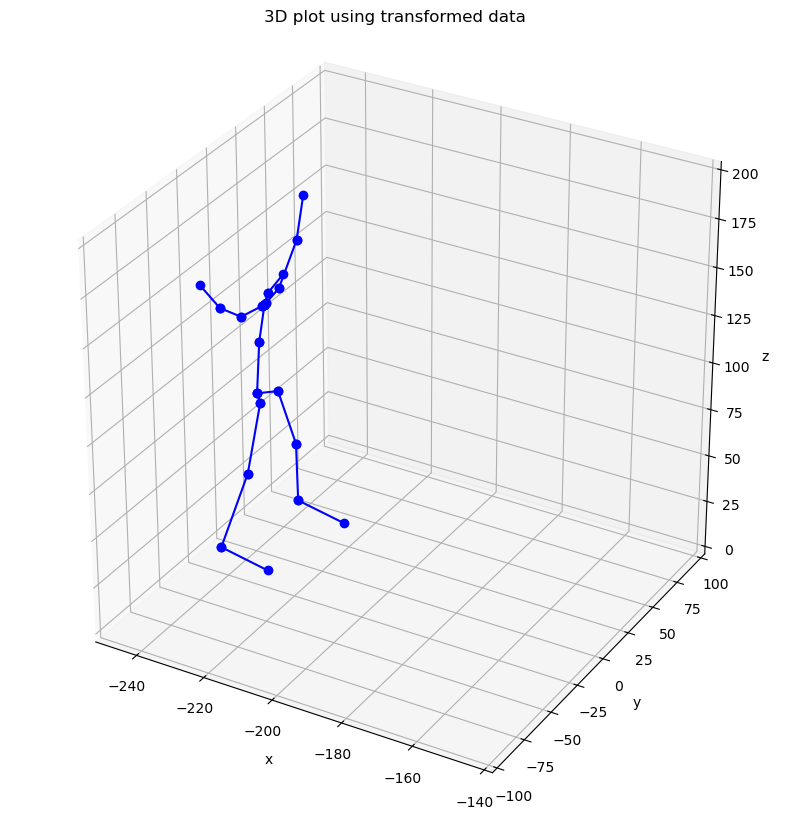

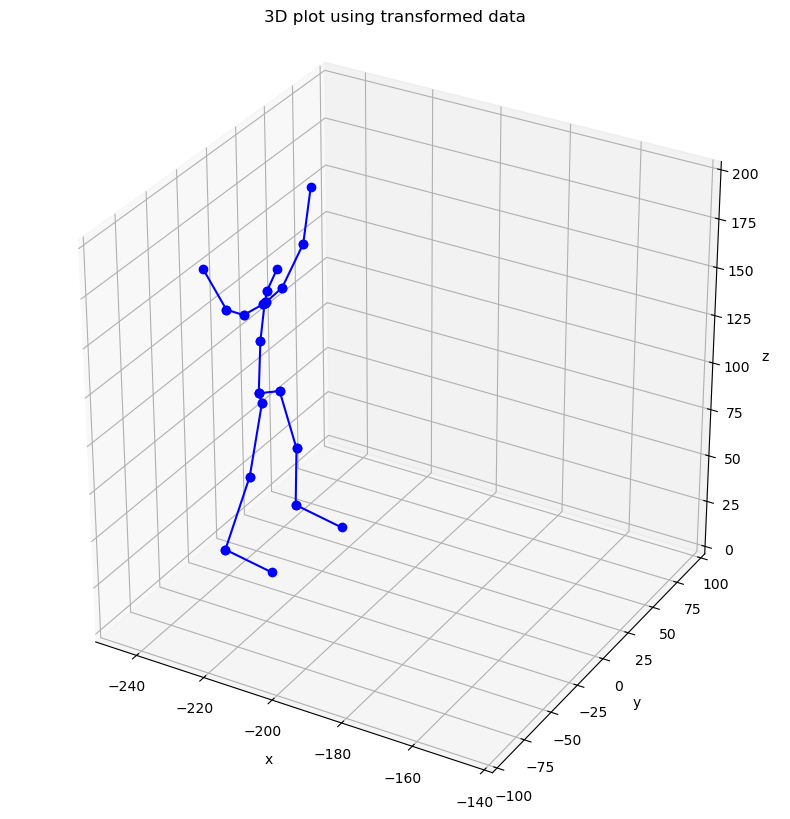

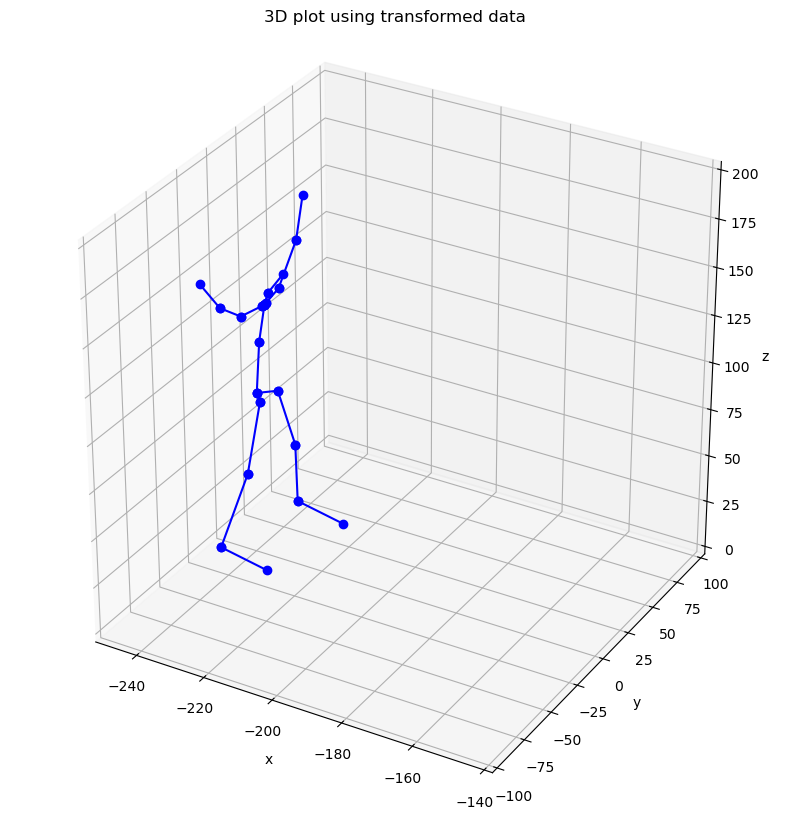

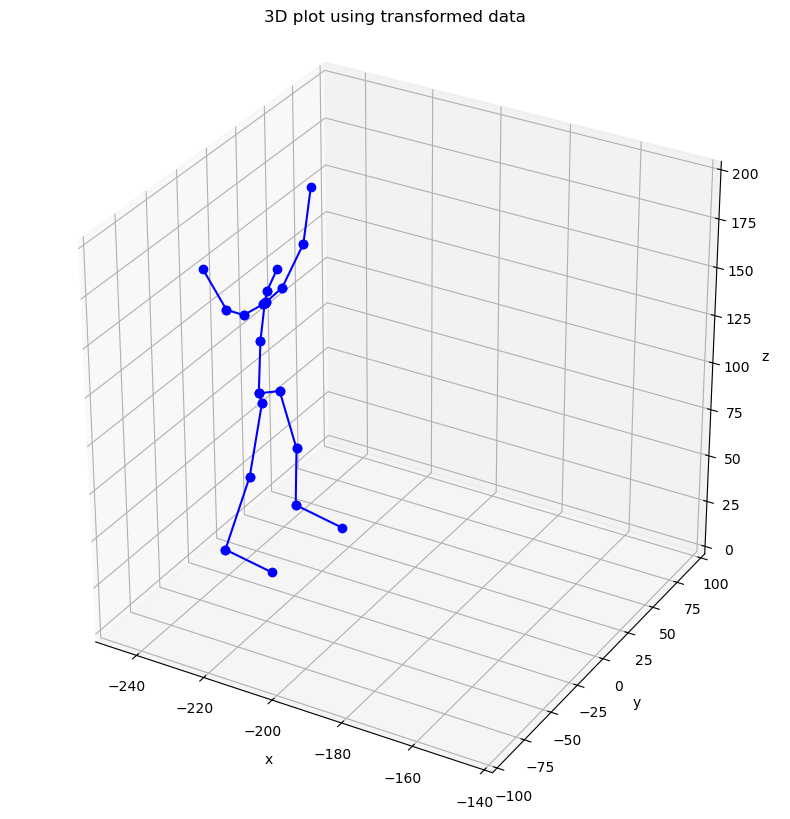

In [13]:
# Verify skeleton data works through animation:
test_skel = np.load('Skeletal Data Filtered/Kinect/smooth_m01_s01_e03_skeleton.npy')
test_skel_inc = np.load('Skeletal Data Filtered/Kinect/smooth_m01_s01_e03_inc_skeleton.npy')
test_skel_normal = np.load('Skeletal Data Normal/Kinect/m01_s01_e03_skeleton.npy')
test_skel_normal_inc = np.load('Skeletal Data Normal/Kinect/m01_s01_e03_inc_skeleton.npy')
visualize_skeleton(test_skel, 'filt_skel.gif')
visualize_skeleton(test_skel_inc, 'filt_skel_inc.gif')
visualize_skeleton(test_skel_normal, 'normal_skel.gif')
visualize_skeleton(test_skel_normal_inc, 'normal_skel_inc.gif')

In [ ]:
# WIP: Motion-based Joints Selection (MJS) for skeletal data compression
test_data = genfromtxt('Filtered Segmented Movements/Vicon/Positions/smooth_m01_s01_e01_positions.txt', delimiter=',')
frames, xyz_joints = test_data.shape
test_data = test_data.reshape(3, xyz_joints//3, frames)
print("New shape: ", test_data.shape)

# Calculate motion of each joint (temporal difference between frames)
m_t = np.abs(np.diff(test_data, axis=2))

# Calculate total motion score for each joint
s_j = np.sum(m_t, axis=(0,2))